In [1]:
#Import all the necessary packages
import numpy as np
import tensorflow as tf
import edward as ed
from edward.models import Normal, Categorical, Laplace, Bernoulli
from edward.util import Progbar
import time
import math
import matplotlib.pyplot as pyplot
from sklearn.metrics import accuracy_score
import random
from observations import mnist as mnist_obs
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

/venv/foo/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#loading the MNIST data
sess = tf.InteractiveSession()
def load_data(path):
    f = open(path,'rb')
    return pickle.load(f)
def accuracy(y_true, y_pred):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            correct += 1
        else:
            pass
    return correct/len(y_true)* 1.
(X_train, y_train), (X_test, y_test) = mnist_obs('./data')
y_train = tf.cast(y_train, tf.int32).eval()
y_test = tf.cast(y_test, tf.int32).eval()

In [3]:
print('Printing some of the training and label data')
print(X_train[:10])
print(y_train[:10])
print('The shape of X_train is (%d, %d)' % X_train.shape)

Printing some of the training and label data
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[5 0 4 1 9 2 1 3 1 4]
The shape of X_train is (60000, 784)


In [4]:
#y_train = y_train.reshape((y_train.shape[0], 1))
#y_test = y_test.reshape((y_test.shape[0], 1))

In [5]:
num_of_class = 10

In [6]:
def one_hot(y_label):
    num_of_samples = y_label.shape[0]
    y_one_hot = np.zeros((num_of_samples, num_of_class))
    y_one_hot[range(num_of_samples), y_label] = 1
    return y_one_hot
#y_train, y_test = one_hot(y_train), one_hot(y_test)
#print('Transform label to one hot encode')
#print(y_train[10:20:])
#print(y_test[10:20])

In [7]:
def categorical(y_one_hot):
    return np.argmax(y_one_hot, axis=1)
#print('Transform one hot encode to label')
#print(categorical(y_train)[:10])

In [8]:
#A function that would randomly split the training and test set
#Default split proportion 0.8
def split_train_test(DATA, y, proportion=0.8):
    data_size = len(DATA)
    train_size = int(proportion * data_size)
    permutation = [i for i in range(data_size)]
    random.shuffle(permutation)
    train_DATA = DATA[permutation[:train_size]]
    train_label = y[permutation[:train_size]]
    test_DATA = DATA[permutation[train_size:]]
    test_label = y[permutation[train_size:]]
    return train_DATA, train_label, test_DATA, test_label

# Probabilistic "PCA" and Bayesian Logistics Regression

In [32]:
#All dimension of input data ranges from [-1, 1]
#thus motivating usages of non-Gaussian noises
#Input: 
#DATA, the data dimension to be reduced
#latent_dim, the latent dimension
#dimension_reduction_coef_var, the variance of the coefficients
#observation_var, 
#sigmoid: whether the sigmoid is used before/after addition of noise, or not used
#inference_method: the method to infer the latent variables, klqp and HMC implemented
#Output:
#qw: the "posterior" of dimension reduction coefficients
#qz: the "posterior" of latent variables
def unsupervised_dimension_reduction(DATA, latent_dim, dimension_reduction_coef_var, 
                                    observation_var, sigmoid='last', inference_method='KLqp'):
    batch_size = 100
    sample_size = DATA.shape[0]
    correlation_count = DATA.shape[1]
    w = Normal(loc=tf.zeros([correlation_count, latent_dim]), 
               scale=dimension_reduction_coef_var * tf.ones([correlation_count, latent_dim]))
    z = Normal(loc=tf.zeros([sample_size, latent_dim]), 
               scale=1.5 * tf.ones([sample_size, latent_dim]))
    targets = None
    if sigmoid == 'last':
        logits = tf.matmul(w, z, transpose_b=True)
        t = tf.sigmoid(logits)
        targets = Bernoulli(t)
    elif sigmoid == 'no_sigmoid':
        targets = Normal(loc=tf.matmul(w, z, transpose_b=True), 
                   scale=observation_var * tf.ones([correlation_count, sample_size]))
    elif sigmoid == 'first':
        t = tf.sigmoid(tf.matmul(w, z, transpose_b=True))
        targets = Bernoulli(t)
    qw = Normal(loc=tf.Variable(tf.random_normal([correlation_count, latent_dim])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([correlation_count, latent_dim]))))
    qz = Normal(loc=tf.Variable(tf.random_normal([sample_size, latent_dim])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([sample_size, latent_dim]))))
    inference = ed.KLqp({w: qw, z: qz}, data={targets: DATA.T})
    inference.run(n_iter=100, n_print=5, n_samples=100)
    '''
    inference.initialize(n_iter = 1000, n_samples = 5)
    tf.global_variables_initializer().run()
    data_generator = generator_xy([qz.eval(), DATA], batch_size)
    n_epoch = 20
    n_iter_per_epoch = DATA.shape[0]
    log_loss = []
    for epoch in range(1, n_epoch + 1):
        for t in range(1, n_iter_per_epoch + 1):
            batch_z, batch_data = next(data_generator)
            info_dict = inference.update(feed_dict={z:batch_z, targets: batch_data.T})
            print(info_dict['loss'])
    '''
    print('finished PCA')
    return qw, qz, w, z

In [33]:
#All dimension of input data ranges from [-1, 1]
#thus motivating usages of non-Gaussian noises
#Input: 
#DATA, the data dimension to be reduced
#qw: the probability distribution dimension reduction coefficients
#latent_dim, the latent dimension
#dimension_reduction_coef_var, the variance of the coefficients
#observation_var, 
#sigmoid: whether the sigmoid is used before/after addition of noise, or not used
#inference_method: the method to infer the latent variables, klqp and HMC implemented
#Output:
#qw: the "posterior" of dimensino reduction coefficients
#qz: the "posterior" of latent variables
def learn_latent_given_w(DATA, qw, latent_dim, observation_var, sigmoid=False):
    sample_size = DATA.shape[0]
    correlation_count = DATA.shape[1]
    z = Normal(loc=tf.zeros([sample_size, latent_dim]), 
               scale=tf.ones([sample_size, latent_dim]))
    targets = None
    if sigmoid == 'last':
        logits = tf.matmul(qw, z, transpose_b=True)
        t = tf.sigmoid(logits)
        targets = Bernoulli(t)
    elif sigmoid == 'no_sigmoid':
        targets = Normal(loc=tf.matmul(qw, z, transpose_b=True), 
                   scale=observation_var * tf.ones([correlation_count, sample_size]))
    elif sigmoid == 'first':
        t = tf.sigmoid(tf.matmul(qw, z, transpose_b=True))
        targets = Bernoulli(t)
    qz = Normal(loc=tf.Variable(tf.random_normal([sample_size, latent_dim])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([sample_size, latent_dim]))))
    inference = ed.KLqp({z: qz}, data={targets: DATA.T})
    inference.run(n_iter=100, n_print=5, n_samples=100)
    print('finished learning z')
    return qz

In [30]:
# Bayesian logistics regression
# Input:
# qz: the distribution of the input variables, either latent/or not dimensions
#y_labels: the labels for this supervised learning
#latent_dim: the dimension of qz
#regression_coef_var: equivalent to regularization term
def bayesian_logistics_regression(qz, y_labels, latent_dim, regression_coef_var, prior):
    if prior == 'gaussian':
        regression_coef = Normal(loc=tf.zeros([num_of_class, latent_dim]), 
               scale=regression_coef_var * tf.ones([num_of_class, latent_dim]))
    elif prior == 'laplacian':
        regression_coef = Laplace(loc=tf.zeros([num_of_class, latent_dim]), 
               scale=regression_coef_var * tf.ones([num_of_class, latent_dim]))
    z = tf.placeholder(tf.float32, [qz.shape[0], latent_dim])
    y = Categorical(logits=tf.matmul(z, regression_coef, transpose_b=True))
    qcoeff = Normal(loc=tf.Variable(tf.random_normal([num_of_class, latent_dim])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([num_of_class, latent_dim]))))
    inference = ed.KLqp({regression_coef: qcoeff}, data={z: qz, y: y_labels})
    inference.run(n_iter=15, n_print=5, n_samples=5)
    print('finished logistics regression')
    return qcoeff, regression_coef

In [23]:
def bayesian_logistics_regression_with_hidden_z(qz, y_labels, latent_dim, regression_coef_var):
    regression_coef = Normal(loc=tf.zeros([num_of_class, latent_dim]), 
               scale=regression_coef_var * tf.ones([num_of_class, latent_dim]))
    y = Categorical(logits=tf.matmul(qz, regression_coef, transpose_b=True))
    qcoeff = Normal(loc=tf.Variable(tf.random_normal([num_of_class, latent_dim])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([num_of_class, latent_dim]))))
    inference = ed.KLqp({regression_coef: qcoeff}, data={y: y_labels})
    inference.run(n_iter=500, n_print=5, n_samples=5)
    return qcoeff, regression_coef

In [13]:
#A wrapper that is created to automatically sample training and test set
#and compare different models
#return the area under the roc curve
def dimension_reduction_and_logistics_regression(latent_dim, 
                                                 dimension_reduction_coef_var, 
                                                 regression_coef_var, 
                                                 sigmoid, 
                                                 observation_var, 
                                                 DATA, 
                                                 labels):
    train_DATA, train_label, test_DATA, test_label = split_train_test(DATA, labels)
    qw, qz_train, w_prior, z_prior = unsupervised_dimension_reduction(train_DATA, latent_dim, 
                                              dimension_reduction_coef_var, 
                                              observation_var, sigmoid)
    qcoef, coef_prior = bayesian_logistics_regression_with_hidden_z(qz_train, train_label, latent_dim, regression_coef_var)
    qz_test = learn_latent_given_w(test_DATA, qw, latent_dim, observation_var, sigmoid)
    n_samples=100
    probas = tf.reduce_mean(tf.stack([tf.sigmoid(tf.matmul(qz_test.sample(), 
                                                           qcoef.sample(), 
                                                           transpose_b=True)) 
                                      for _ in range(n_samples)],axis=0), axis=0)
    score = probas.eval()
    y_pred = categorical(score)
    return accuracy_score(y_pred, test_label), qw, w_prior, qz_train, z_prior, qcoef, coef_prior

In [14]:
#A wrapper for raw bayesian logistics regression
#return the area under the roc curve
def raw_bayesian_logistics_regression(regression_coef_var, DATA, labels, prior='gaussian'):
    train_DATA, train_label, test_DATA, test_label = split_train_test(DATA, labels)
    dimension = DATA.shape[1]
    qcoef, coef_prior = bayesian_logistics_regression(train_DATA, train_label, dimension, regression_coef_var, prior)
    n_samples = 100
    test_z = tf.placeholder(tf.float32, test_DATA.shape)
    probas = tf.reduce_mean(tf.stack([tf.sigmoid(tf.matmul(test_z, 
                                                           qcoef.sample(), 
                                                           transpose_b=True)) 
                                      for _ in range(n_samples)],axis=0), axis=0)
    score = probas.eval(feed_dict={test_z: test_DATA})
    y_pred = categorical(score)
    return accuracy_score(y_pred, test_label), qcoef, coef_prior

15/15 [100%] ██████████████████████████████ Elapsed: 10s | Loss: 48855948.000
The accuracy achieved by raw bayesian logistics regression is 0.672917


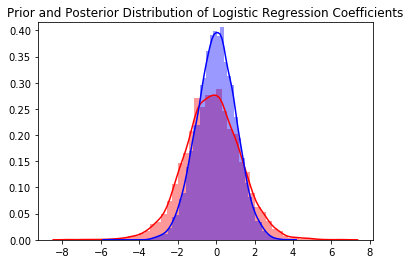

In [15]:
regression_coef_var = 1
acc, qcoef, coef_prior = raw_bayesian_logistics_regression(regression_coef_var, X_train, y_train)
print('The accuracy achieved by raw bayesian logistics regression is %f' 
      % acc)

pos_encode = qcoef.sample().eval()
pri_encode = coef_prior.sample().eval()

sns.distplot(np.ndarray.flatten(pos_encode), color = 'red')
sns.distplot(np.ndarray.flatten(pri_encode), color = 'blue')
plt.title('Prior and Posterior Distribution of Logistic Regression Coefficients')
plt.show()

The posterior (red) and the prior (blue) of the coefficient distribution both characterize the central tendency; however, the prior is much concentrated in the center, and we observe that the posterior have a heavier tail. Hence, we implement the Laplacian distribution as the prior.

The following is the result of using a laplacian prior.

15/15 [100%] ██████████████████████████████ Elapsed: 12s | Loss: 41066724.000
The accuracy achieved by raw bayesian logistics regression is 0.749750


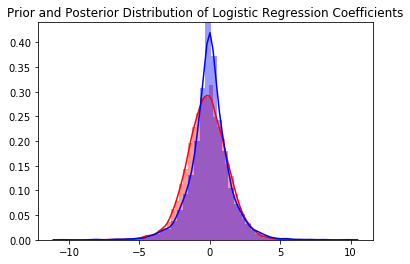

In [16]:
regression_coef_var = 1
acc, qcoef, coef_prior = raw_bayesian_logistics_regression(regression_coef_var, X_train, y_train, prior='laplacian')
print('The accuracy achieved by raw bayesian logistics regression is %f' 
      % acc)

pos_encode = qcoef.sample().eval()
pri_encode = coef_prior.sample().eval()

sns.distplot(np.ndarray.flatten(pos_encode), color = 'red')
sns.distplot(np.ndarray.flatten(pri_encode), color = 'blue')
plt.title('Prior and Posterior Distribution of Logistic Regression Coefficients')
plt.show()

The posterior (red) and the prior (blue) of the coefficient distribution both characterize the central tendency and the heavy tail. The accuracy improved by 2 percent.

15/15 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 49351364.000
The accuracy achieved by raw bayesian logistics regression is 0.761000


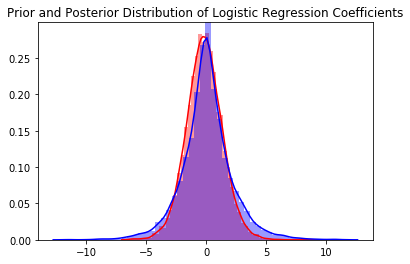

In [ ]:
regression_coef_var = 1.5
acc, qcoef, coef_prior = raw_bayesian_logistics_regression(regression_coef_var, X_train, y_train, prior='laplacian')
print('The accuracy achieved by raw bayesian logistics regression is %f' 
      % acc)

pos_encode = qcoef.sample().eval()
pri_encode = coef_prior.sample().eval()

sns.distplot(np.ndarray.flatten(pos_encode), color = 'red')
sns.distplot(np.ndarray.flatten(pri_encode), color = 'blue')
plt.title('Prior and Posterior Distribution of Logistic Regression Coefficients')
plt.show()

According to the plot, the prior and posterior match nicely. The performance again went up 4 percent. 

Now let's try bayesian logisitcs regression followed by probabilistic PCA

In [34]:
X_train = X_train[:5000]
y_train = y_train[:5000]
latent_dim = 10
dimension_reduction_coef_var = 1 
regression_coef_var = 1 
sigmoid = 'no_sigmoid'
observation_var = 0.01
acc, qw, w_prior, qz_train, z_prior, qcoef, coef_prior = dimension_reduction_and_logistics_regression(latent_dim, 
                                                        dimension_reduction_coef_var,
                                                        regression_coef_var, 
                                                        sigmoid,
                                                        observation_var, 
                                                        X_train, 
                                                        y_train)
print('The accuracy achieved by bayesian logistics regression followed by dimension reduction is %f' 
      % acc)

100/100 [100%] ██████████████████████████████ Elapsed: 556s | Loss: 50192573267968.000
finished PCA
500/500 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 102.443
100/100 [100%] ██████████████████████████████ Elapsed: 165s | Loss: 12427233067008.000
finished learning z
The accuracy achieved by bayesian logistics regression followed by dimension reduction is 0.107000


256 latent dimensions yeilds trivial performance. Try a smaller dimension

In [ ]:
latent_dim = 10
dimension_reduction_coef_var = 1.5
regression_coef_var = 1.5
sigmoid = 'last'
observation_var = 0.001
acc, qw, w_prior, qz_train, z_prior, qcoef, coef_prior = dimension_reduction_and_logistics_regression(latent_dim, 
                                                        dimension_reduction_coef_var,
                                                        regression_coef_var, 
                                                        sigmoid,
                                                        observation_var, 
                                                        X_train, 
                                                        y_train)
print('The accuracy achieved by bayesian logistics regression followed by dimension reduction is %f' 
      % acc)

In [ ]:
print('The coefficient distribution for latent variable')
pos_encode = qz_train.sample().eval()
pri_encode = z_prior.sample().eval()

sns.distplot(np.ndarray.flatten(pos_encode), color = 'red')
sns.distplot(np.ndarray.flatten(pri_encode), color = 'blue')
plt.title('Prior and Posterior Distribution of latent variable')
plt.show()

In [ ]:
print('The coefficient distribution for dimension reduction')
pos_encode = qw.sample().eval()
pri_encode = w_prior.sample().eval()

sns.distplot(np.ndarray.flatten(pos_encode), color = 'red')
sns.distplot(np.ndarray.flatten(pri_encode), color = 'blue')
plt.title('Prior and Posterior Distribution of Dimension Reduction coefficient')
plt.show()

In [ ]:
print('The prior and posterior of bayesian regression coefficient')
pos_encode = qcoef.sample(100).eval()
pri_encode = coef_prior.sample(100).eval()

sns.distplot(np.ndarray.flatten(pos_encode), color = 'red')
sns.distplot(np.ndarray.flatten(pri_encode), color = 'blue')
plt.title('Prior and Posterior Distribution of regression coefficient')
plt.show()

In [ ]:
latent_dim = 256
dimension_reduction_coef_var = 1.5
regression_coef_var = 1.5 
sigmoid = 'last'
observation_var = 0.01
latent_dim = 10
acc, qw, w_prior, qz_train, z_prior, qcoef, coef_prior = dimension_reduction_and_logistics_regression(latent_dim, 
                                                        dimension_reduction_coef_var,
                                                        regression_coef_var, 
                                                        sigmoid,
                                                        observation_var, 
                                                        X_train, 
                                                        y_train)
print('The accuracy achieved by bayesian logistics regression followed by dimension reduction is %f' 
      % acc)